In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler
from scipy.stats import rankdata

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
#### Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home12/khou/scTRS_results/'

# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs', flag_scale=False, flag_filter_genes=True)
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))


Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22953
# time=17.2s


In [3]:
# Genearate null gene sets
np.random.seed(0)
dic_trait_geneset = {}
gs_size_list = [20, 50, 200, 500]
n_rep = 10

df_gene = pd.DataFrame(index=data_facs_ct.var_names)
df_gene['mean'] = data_facs_ct.X.mean(axis=0).T
df_gene = df_gene.sort_values(by=['mean'])

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        
        # Highly expressed
        ind_select = np.random.permutation(2000)[:n_gene]
        dic_trait_geneset['null_size%d_rep%d'%(n_gene,i_rep)] =  list(df_gene.index[-2000:][ind_select])

In [4]:
# precompute some statistics
adata = data_facs_ct.copy()
mean, var = util.get_sparse_var(adata.X, axis=0)
adata.var['mean'] = mean
adata.var['var'] = var
adata.var['mean_rank'] = rankdata(adata.var['mean'], method='ordinal') - 1

mean, var = util.get_sparse_var(adata.X, axis=1)
adata.obs['mean'] = mean
adata.obs['var'] = var

In [5]:
null_trait_list = [x for x in dic_trait_geneset.keys() if 'null_size50_' in x]

In [9]:
def match_marginal_distribution(x, target, method='full'):
    """
    match marginal distribution of `x` according to the reference `target`
    
    Params:
        x: 1d array
        target: 1d array
        
        x and target are assumed to have the same length for now
    """
    assert(len(x) == len(target))
    assert (method in ['full']), "Only [full] is supported"
    x_transformed = np.zeros_like(x)
    rn1 = np.random.random(x.size)
    rn2 = np.random.random(x.size)
    # ties get randomly assigned
    x_transformed[np.lexsort((rn1, x))] = target[np.lexsort((rn2, target))]
    # x_transformed[np.argsort(x)] = target[np.argsort(target)]
    return x_transformed

def generate_null_genes(adata, gene_list, match_criterion='mean_equal', num_rep=1, random_width=10):
    """
        Generate null gene set
        adata: AnnData
        gene_list: original gene list, should be a list of gene names
        match_criterion: One of 'mean_equal', 'mean_inflate'
        num_rep: for every gene in the gene list, how many replicated.
        return a list of null genes
    """
    temp_df = adata.var[['mean', 'var', 'mean_rank']].copy()
    temp_df = temp_df.sort_values('mean_rank')
    
    assert (match_criterion in ['mean_equal', 'mean_equal_near_var']), "method must be in [mean_equal, mean_equal_near_var]"
    
    if match_criterion == 'mean_equal' or match_criterion == 'mean_equal_near_var':
        random_range = np.concatenate([np.arange(-random_width, 0), np.arange(1, random_width + 1)])
    
    # ordered gene_list
    gene_list_rank = temp_df.loc[gene_list, 'mean_rank'].values
    gene_list_null = []
    
    for rank in gene_list_rank:
        search_range = rank + random_range
        search_range = search_range[(0 <= search_range) & (search_range < len(adata.var_names))]
        choices = set(search_range) - set(gene_list_rank) - set(gene_list_null)
        
        mean_matched_df = temp_df.iloc[list(choices), :]
        if match_criterion == 'mean_equal':
            null_genes = np.random.choice(mean_matched_df['mean_rank'], replace=False, size=num_rep)
            
        elif match_criterion == 'mean_equal_near_var':
            null_genes = mean_matched_df['mean_rank'][(mean_matched_df['var'] - temp_df.iloc[rank]['var']).abs().argsort()[0 : num_rep]].values
        
        gene_list_null.extend(null_genes)
    
    # double check no replicates
    assert(len(set(gene_list_null)) == len(gene_list_null))
    gene_list_null = np.array(gene_list_null).reshape(len(gene_list), num_rep)

    gene_list_null = [temp_df.index[gene_list_null[:, rep_i]] for rep_i in range(num_rep)]
    
    return gene_list_null

def generate_dist(
               adata, 
               trait_gene_list,
               null_gene_list,
               flag_correct_background=False):
    
    trait_trs = adata[:, trait_gene_list].X.mean(axis=1).A1
    trs_X = adata[:, trait_gene_list].X.toarray()

    null_X = adata[:, null_gene_list].X.toarray()
    # for each null gene
    for gene_i in range(null_X.shape[1]):
        null_X[:, gene_i] = match_marginal_distribution(x=null_X[:, gene_i], target = trs_X[:, gene_i])
    null_trs = null_X.mean(axis=1)

    # Cell background correction
    if flag_correct_background:
        v_mean, v_var = adata.obs['mean'].values, adata.obs['var'].values
        v_std = np.sqrt(v_var)
        trait_trs = (trait_trs - v_mean) / v_std * \
                                np.sqrt(len(trait_gene_list))
        null_trs = (null_trs - v_mean) / v_std * \
                                np.sqrt(len(null_gene_list))
    return trait_trs, null_trs

In [7]:
# generate null gene set
np.random.seed(0)
dic_null_geneset = dict()
for trait in null_trait_list:
    gene_list = dic_trait_geneset[trait]
    dic_null_geneset[trait] = generate_null_genes(adata, gene_list, match_criterion='mean_equal', num_rep=1)[0].values

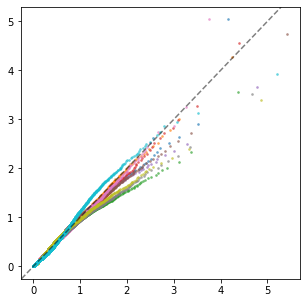

In [10]:
plt.figure(figsize=(5, 5))
for trait in null_trait_list:
    trait_gene_list = dic_trait_geneset[trait]
    null_gene_list = dic_null_geneset[trait]
    trait_trs, null_trs = generate_dist(adata, trait_gene_list, null_gene_list)
    
    trait_trs = (trait_trs - trait_trs.mean()) / trait_trs.std()
    null_trs = (null_trs - null_trs.mean()) / null_trs.std()
        
    empi_pval = md.get_p_from_empi_null(trait_trs, null_trs)
    empi_logpval = -np.log10(empi_pval)

    normal_pval = np.random.rand(10000)
    normal_logpval = -np.log10(normal_pval)
    util.qqplot(x=normal_logpval, y=empi_logpval, quantiles=2000, s=3, alpha=0.5)
plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
plt.show()

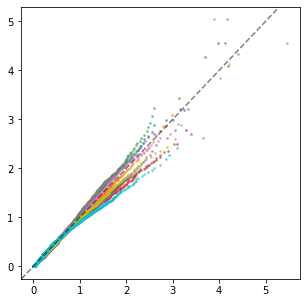

In [11]:
# switched trait gene set and null gene set
dic_null_geneset, dic_trait_geneset = dic_trait_geneset, dic_null_geneset

plt.figure(figsize=(5, 5))
for trait in null_trait_list:
    trait_gene_list = dic_trait_geneset[trait]
    null_gene_list = dic_null_geneset[trait]
    trait_trs, null_trs = generate_dist(adata, trait_gene_list, null_gene_list)
    
    trait_trs = (trait_trs - trait_trs.mean()) / trait_trs.std()
    null_trs = (null_trs - null_trs.mean()) / null_trs.std()
        
    empi_pval = md.get_p_from_empi_null(trait_trs, null_trs)
    empi_logpval = -np.log10(empi_pval)

    normal_pval = np.random.rand(10000)
    normal_logpval = -np.log10(normal_pval)
    util.qqplot(x=normal_logpval, y=empi_logpval, quantiles=2000, s=3, alpha=0.5)
plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
plt.show()